# CNN Model to determine whether an image is Normal, Covid, Viral Pneumonia

Import libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1. Data Gathering
1. From a sample provided by the professor that contains testing, validating,  and training data of radiography images of lungs.
2. The lungs are divided into folders labelled Normal, Covid, and Viral Pneumonia.

# 2. Data Preparation
1. Split the training and the testing dataset randomly
2. Know which cases are which; already done using the folders.
3. Pre-processing for the model.

In [2]:
image_size = (180, 180)
batch_size = 32

### Training Dataset
249 data is within the training dataset and 20% of it is splited for validation. Seed is the randomness that can be traced by the seed number.

In [3]:
training_dataset = tf.keras.preprocessing.image_dataset_from_directory("C:\\Users\\kylle\\Data Science\\CNN PRACTICE\\images\\train",
    validation_split=0.2,
    subset="training",
    seed=999,
    image_size=image_size,
    batch_size=batch_size,
)

Found 249 files belonging to 3 classes.
Using 200 files for training.


### Testing Dataset
65 data belongs to the testing dataset and the same procedure was done

In [11]:
testing_dataset = tf.keras.preprocessing.image_dataset_from_directory("C:\\Users\\kylle\\Data Science\\CNN PRACTICE\\images\\test",
    validation_split=0.2,
    subset="validation",
    seed=999,
    image_size=image_size,
    batch_size=batch_size,
)

Found 65 files belonging to 3 classes.
Using 13 files for validation.


### Classes
For the model and prediction the classes are extracted from the training dataset 

In [7]:
classes_names = training_dataset.class_names
classes_names

['Covid', 'Normal', 'Viral Pneumonia']

### Sample of images 

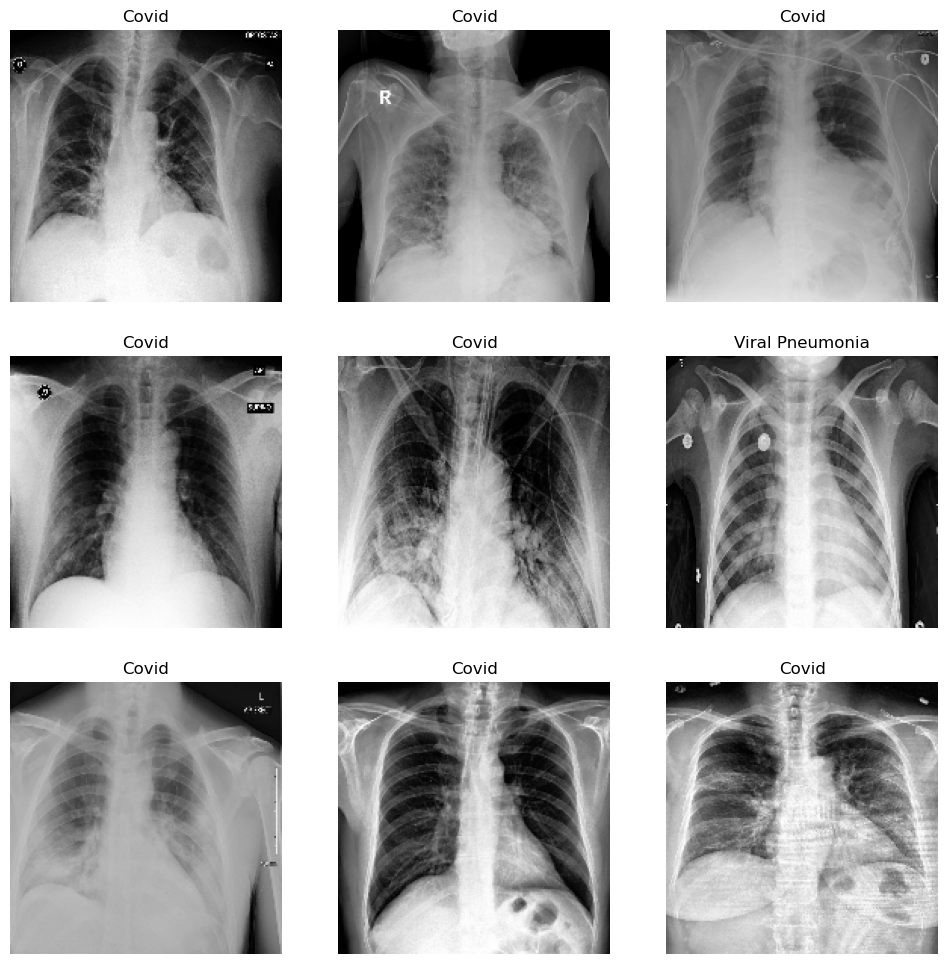

In [12]:
plt.figure(figsize=(12, 12))
for images, labels in training_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(classes_names[labels[i]])
    plt.axis("off")

### Data Augmentation
- Done to compensate for the lack of the amount of dataset. 
- The data augmentation done here is by flipping the image, rotating, and zooming.

In [13]:
data_augmentation = keras.Sequential(
    [
     layers.experimental.preprocessing.RandomFlip("horizontal"),
     layers.experimental.preprocessing.RandomRotation(0.05),
     layers.experimental.preprocessing.RandomZoom(0.10)
    ]
)

### Data Augmentation Visualization
- in the following images you can see the rotation, flipping as well as zooming in order to reuse the data during training while increasing the accuracy of the model.

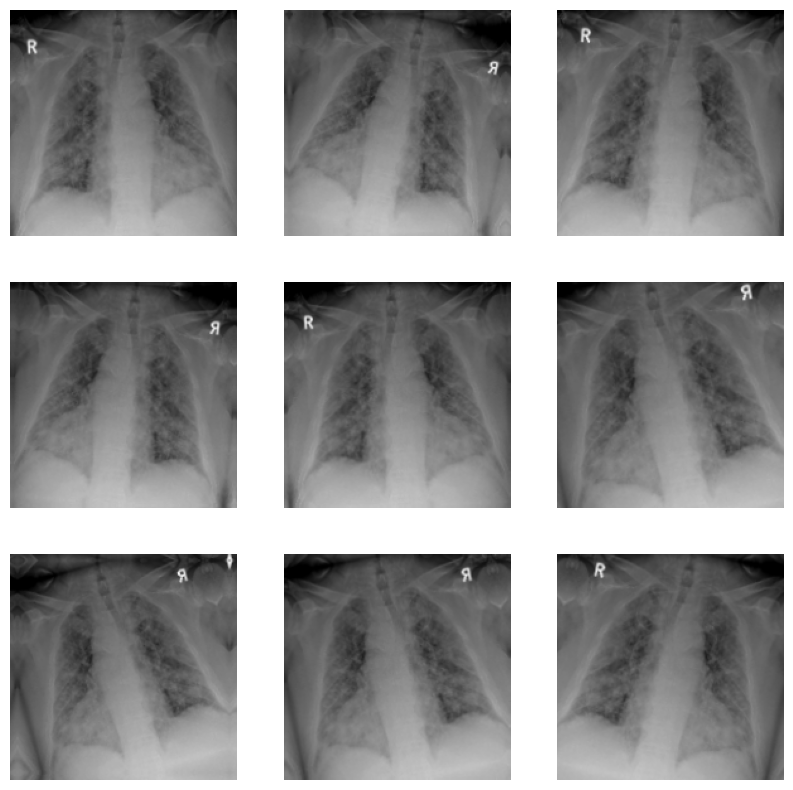

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in training_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Prefetch data
- to reduce the load during modelling

In [17]:
training_dataset = training_dataset.prefetch(buffer_size=32)
testing_dataset = testing_dataset.prefetch(buffer_size=32)

# 3. Choosing the Model
- CNN model with multiple laters

In [18]:
keras.backend.clear_session()

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 5, strides=2, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)
    x = layers.Conv2D(64, 5, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    for size in [128, 256, 512]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(size, 5, padding="same")(x)
        x = layers.MaxPool2D(3, strides=2, padding="same")(x)

    x = layers.Dropout(0.5)(x)
    x = layers.SeparableConv2D(724, 3, padding="same")(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPool2D(3, strides=2, padding="same")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)

    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

### Visualization of the layers of the model

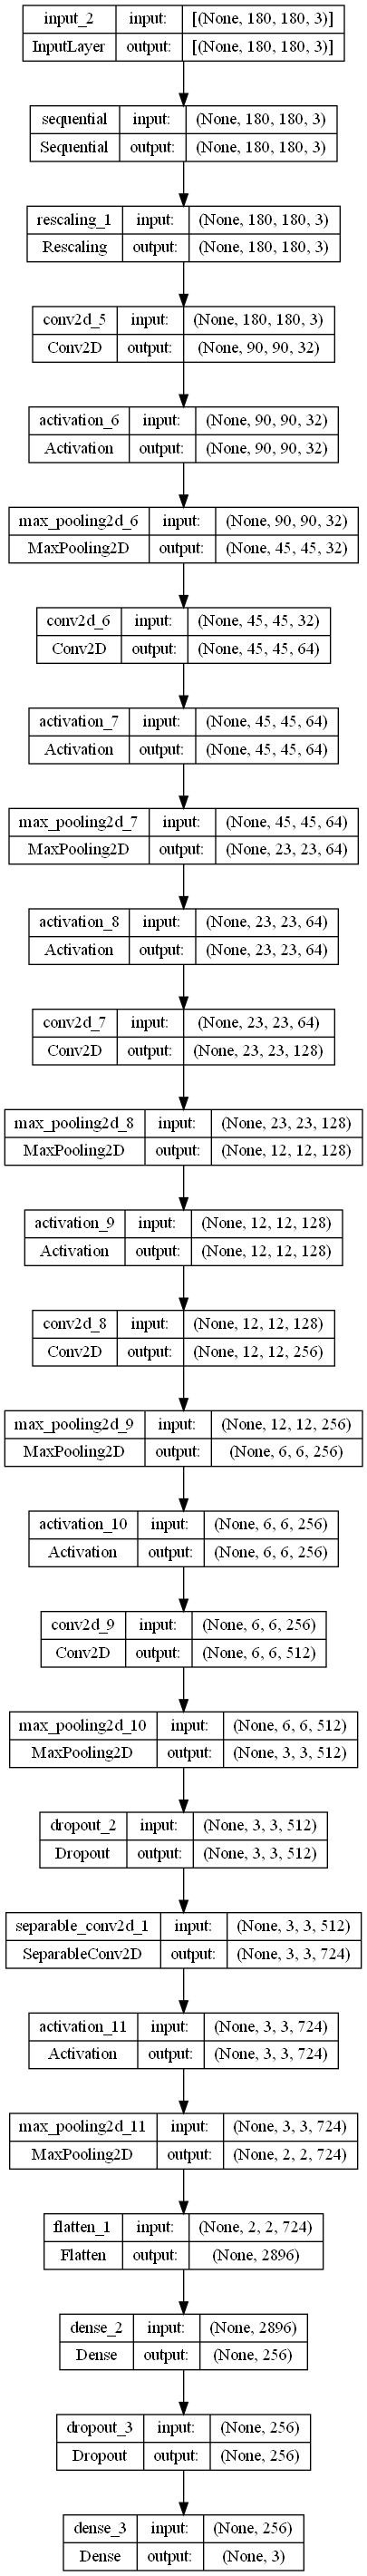

In [20]:
model = make_model(input_shape=image_size + (3,), num_classes=3)
keras.utils.plot_model(model, show_shapes=True)

In [21]:
def scheduler(epoch, lr):
  if epoch < 9:
    return lr
  else:
    return lr * tf.math.exp(-0.008)

lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [22]:
epochs = 60
model.compile(optimizer= 'Adam',loss ='sparse_categorical_crossentropy',metrics =["accuracy"])

# 4. Training the model and hyperparameters

In [25]:
history = model.fit(
    training_dataset, epochs = epochs, 
    callbacks = [lr_callback],
    validation_data = testing_dataset)

Epoch 1/60
7/7 [==============================] - 4s 365ms/step - loss: 1.1089 - accuracy: 0.3150 - val_loss: 1.1068 - val_accuracy: 0.1538 - lr: 0.0010
Epoch 2/60
7/7 [==============================] - 3s 311ms/step - loss: 1.0884 - accuracy: 0.4550 - val_loss: 1.1291 - val_accuracy: 0.1538 - lr: 0.0010
Epoch 3/60
7/7 [==============================] - 3s 314ms/step - loss: 1.0808 - accuracy: 0.4550 - val_loss: 1.1591 - val_accuracy: 0.1538 - lr: 0.0010
Epoch 4/60
7/7 [==============================] - 3s 318ms/step - loss: 1.0607 - accuracy: 0.4550 - val_loss: 1.1892 - val_accuracy: 0.1538 - lr: 0.0010
Epoch 5/60
7/7 [==============================] - 3s 342ms/step - loss: 1.0215 - accuracy: 0.4550 - val_loss: 1.0870 - val_accuracy: 0.6154 - lr: 0.0010
Epoch 6/60
7/7 [==============================] - 3s 312ms/step - loss: 0.8703 - accuracy: 0.5450 - val_loss: 1.3433 - val_accuracy: 0.5385 - lr: 0.0010
Epoch 7/60
7/7 [==============================] - 3s 311ms/step - loss: 0.7748 - a

7/7 [==============================] - 3s 310ms/step - loss: 0.1795 - accuracy: 0.9300 - val_loss: 0.5234 - val_accuracy: 0.6923 - lr: 7.0328e-04
Epoch 54/60
7/7 [==============================] - 3s 317ms/step - loss: 0.1378 - accuracy: 0.9600 - val_loss: 0.1452 - val_accuracy: 0.9231 - lr: 6.9768e-04
Epoch 55/60
7/7 [==============================] - 3s 305ms/step - loss: 0.1587 - accuracy: 0.9400 - val_loss: 0.4737 - val_accuracy: 0.7692 - lr: 6.9212e-04
Epoch 56/60
7/7 [==============================] - 3s 312ms/step - loss: 0.1021 - accuracy: 0.9600 - val_loss: 0.0912 - val_accuracy: 0.9231 - lr: 6.8660e-04
Epoch 57/60
7/7 [==============================] - 3s 304ms/step - loss: 0.0942 - accuracy: 0.9600 - val_loss: 0.4894 - val_accuracy: 0.7692 - lr: 6.8113e-04
Epoch 58/60
7/7 [==============================] - 3s 309ms/step - loss: 0.1244 - accuracy: 0.9650 - val_loss: 0.0941 - val_accuracy: 0.9231 - lr: 6.7570e-04
Epoch 59/60
7/7 [==============================] - 3s 326ms/step

# 5. Evaluating the model

In [26]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epochs)

### Training vs Validation Accuracy graph
- shows how the accuracy increases erratically over the number of epoch. This could mean that the model need regularisation, increased batch size, reduced learning rate, or increasing the amount of epochs. 

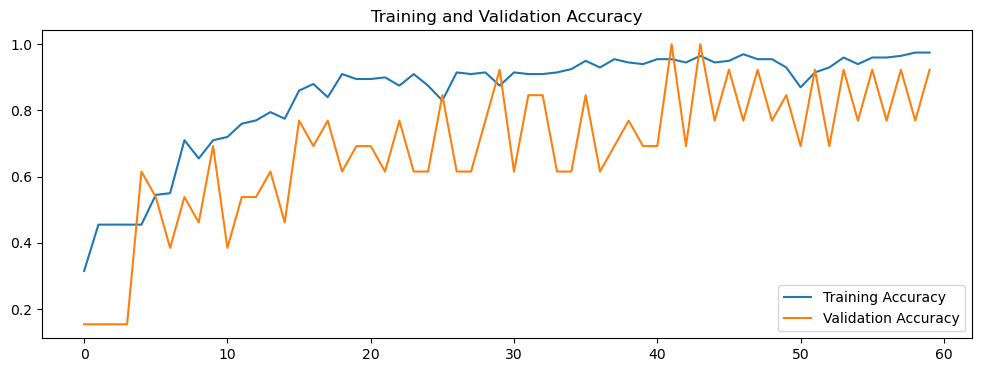

In [31]:
plt.figure(figsize=(12, 4))
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()


### Training vs Validation loss graph
- shows how the loss decreases erratically over the number of epoch. This could mean that the model need regularisation or increased image augmentation techniques since it may be a sign of overfitting. However it is normal for spiky loss when using optimizer Adam 

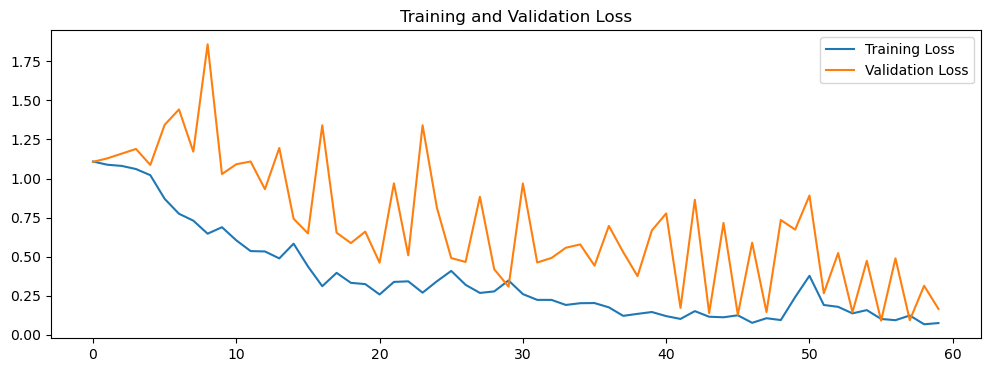

In [32]:
plt.figure(figsize=(12, 4))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###  Final Training and Validation accuracy versus the Testing dataset.

In [43]:
train_acc=history.history['accuracy'][-1]
val_acc=history.history['val_accuracy'][-1]
print("Training Accuracy:", train_acc*100, "%") 
print("Validation Accuracy:", val_acc*100, "%")

Training Accuracy: 97.50000238418579 %
Validation Accuracy: 92.30769276618958 %


# 7. Prediction
1. Get the image paths for this method
2. Use an Array that will be used in the following cell
3. Use model.predict to determine which class does the image belong to.

In [33]:
image_path = "C:\\Users\\kylle\\Data Science\\CNN PRACTICE\\validation\\pic1.jpeg"
image_path2 = "C:\\Users\\kylle\\Data Science\\CNN PRACTICE\\validation\\pic2.jpeg"
image_path3 = "C:\\Users\\kylle\\Data Science\\CNN PRACTICE\\validation\\pic3.jpeg"
image_path4 = "C:\\Users\\kylle\\Data Science\\CNN PRACTICE\\validation\\pic4.jpeg"
image_path5 = "C:\\Users\\kylle\\Data Science\\CNN PRACTICE\\validation\\pic5.jpeg"
image_path6 = "C:\\Users\\kylle\\Data Science\\CNN PRACTICE\\validation\\pic6.jpeg"
image_path7 = "C:\\Users\\kylle\\Data Science\\CNN PRACTICE\\validation\\pic7.jpg"
image_path8 = "C:\\Users\\kylle\\Data Science\\CNN PRACTICE\\validation\\pic8.jpeg"
image_path9 = "C:\\Users\\kylle\\Data Science\\CNN PRACTICE\\validation\\pic9.jpeg"
image_path10 = "C:\\Users\\kylle\\Data Science\\CNN PRACTICE\\validation\\pic10.jpeg"
merged_path = [image_path,image_path2,image_path3,image_path4,image_path5,image_path6,image_path7,image_path8,image_path9,image_path10]

In [35]:
for img_path in merged_path:
    img = keras.preprocessing.image.load_img(
        img_path, target_size=image_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])
    
    print("This image most likely belongs to a {} class.".format(classes_names[np.argmax(score)]))

1/1 [==============================] - 0s 20ms/step
This image most likely belongs to a Normal class.
1/1 [==============================] - 0s 25ms/step
This image most likely belongs to a Covid class.
1/1 [==============================] - 0s 26ms/step
This image most likely belongs to a Viral Pneumonia class.
1/1 [==============================] - 0s 24ms/step
This image most likely belongs to a Viral Pneumonia class.
1/1 [==============================] - 0s 26ms/step
This image most likely belongs to a Normal class.
1/1 [==============================] - 0s 24ms/step
This image most likely belongs to a Covid class.
1/1 [==============================] - 0s 27ms/step
This image most likely belongs to a Covid class.
1/1 [==============================] - 0s 27ms/step
This image most likely belongs to a Viral Pneumonia class.
1/1 [==============================] - 0s 27ms/step
This image most likely belongs to a Covid class.
1/1 [==============================] - 0s 24ms/step
This im